## Imports
List Python and ML-related libraries used throughout training.

In [1]:
# Core libraries
import os
import json
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print('TensorFlow version:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))


2025-11-30 14:40:37.749119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764513637.940472      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764513637.993301      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Paths & Configuration
Define dataset roots, metadata paths, and training hyperparameters.

In [2]:
# Check if running in Kaggle environment
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    # Kaggle paths
    DATA_ROOT = '/kaggle/input/celeb-df-images/output'
    IMAGES_DIR = os.path.join(DATA_ROOT, 'images', 'celebdf')
    METADATA_DIR = os.path.join(DATA_ROOT, 'metadata')
    MODELS_DIR = '/kaggle/working/models'
    PLOTS_DIR = '/kaggle/working/plots'
else:
    # Local paths for testing
    DATA_ROOT = 'data'
    IMAGES_DIR = os.path.join(DATA_ROOT, 'images', 'celebdf')
    METADATA_DIR = os.path.join(DATA_ROOT, 'metadata')
    MODELS_DIR = 'models'
    PLOTS_DIR = 'plots'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Metadata files
LABELS_CSV = os.path.join(METADATA_DIR, 'labels_celebdf.csv')
DETECTIONS_JSON = os.path.join(METADATA_DIR, 'detections_celebdf.json')

# Hyperparameters
CONFIG = {
    # Data
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'random_state': 42,
    
    # ResNet50 Configuration
    'resnet50': {
        'img_size': 224,
        'batch_size': 32,
        'phase1_epochs': 10,     # Head-only training
        'phase2_epochs': 20,     # Fine-tuning
        'phase1_lr': 1e-3,
        'phase2_lr': 1e-5,
        'dropout_rate': 0.5,
    },
    
    # EfficientNetB7 Configuration
    'efficientnetb7': {
        'img_size': 380,
        'batch_size': 16,        # Smaller batch due to larger model
        'phase1_epochs': 10,
        'phase2_epochs': 20,
        'phase1_lr': 1e-3,
        'phase2_lr': 1e-5,
        'dropout_rate': 0.5,
    },
    
    # Training callbacks
    'early_stopping_patience': 5,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.5,
    'reduce_lr_min': 1e-7,
}

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'GPU configured: {len(gpus)} GPU(s) available')
    except RuntimeError as e:
        print(e)
else:
    print('Running on CPU')

print('\n=== Configuration ===')
print(f'Data Root: {DATA_ROOT}')
print(f'Images Directory: {IMAGES_DIR}')
print(f'Metadata Directory: {METADATA_DIR}')
print(f'Models Directory: {MODELS_DIR}')
print(f'Plots Directory: {PLOTS_DIR}')
print(f'\nLabels CSV: {LABELS_CSV}')
print(f'Detections JSON: {DETECTIONS_JSON}')
print(f'\nTraining Config:')
for key, value in CONFIG.items():
    if isinstance(value, dict):
        print(f'  {key}:')
        for k, v in value.items():
            print(f'    {k}: {v}')
    else:
        print(f'  {key}: {value}')


GPU configured: 2 GPU(s) available

=== Configuration ===
Data Root: /kaggle/input/celeb-df-images/output
Images Directory: /kaggle/input/celeb-df-images/output/images/celebdf
Metadata Directory: /kaggle/input/celeb-df-images/output/metadata
Models Directory: /kaggle/working/models
Plots Directory: /kaggle/working/plots

Labels CSV: /kaggle/input/celeb-df-images/output/metadata/labels_celebdf.csv
Detections JSON: /kaggle/input/celeb-df-images/output/metadata/detections_celebdf.json

Training Config:
  train_split: 0.7
  val_split: 0.15
  test_split: 0.15
  random_state: 42
  resnet50:
    img_size: 224
    batch_size: 32
    phase1_epochs: 10
    phase2_epochs: 20
    phase1_lr: 0.001
    phase2_lr: 1e-05
    dropout_rate: 0.5
  efficientnetb7:
    img_size: 380
    batch_size: 16
    phase1_epochs: 10
    phase2_epochs: 20
    phase1_lr: 0.001
    phase2_lr: 1e-05
    dropout_rate: 0.5
  early_stopping_patience: 5
  reduce_lr_patience: 3
  reduce_lr_factor: 0.5
  reduce_lr_min: 1e-07


## Model Definition
Construct the EfficientNetB7 and ResNet50 classifier head used for both training phases.

In [3]:
def build_resnet50_model(img_size=224, dropout_rate=0.5, learning_rate=1e-3):
    """
    Build ResNet50 model with custom classification head for binary deepfake detection.
    
    Args:
        img_size: Input image size (default 224 for ResNet50)
        dropout_rate: Dropout rate for regularization
        learning_rate: Learning rate for Adam optimizer
    
    Returns:
        Compiled Keras model
    """
    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    # Freeze base model initially (for phase 1 training)
    base_model.trainable = False
    
    # Build custom classification head
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='ResNet50_Deepfake_Detector')
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model


def build_efficientnetb7_model(img_size=380, dropout_rate=0.5, learning_rate=1e-3):
    """
    Build EfficientNetB7 model with custom classification head for binary deepfake detection.
    
    Args:
        img_size: Input image size (default 380 for EfficientNetB7)
        dropout_rate: Dropout rate for regularization
        learning_rate: Learning rate for Adam optimizer
    
    Returns:
        Compiled Keras model
    """
    # Load pre-trained EfficientNetB7 (without top classification layer)
    base_model = EfficientNetB7(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    # Freeze base model initially (for phase 1 training)
    base_model.trainable = False
    
    # Build custom classification head
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='EfficientNetB7_Deepfake_Detector')
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model


# Test model creation
print('=== Testing Model Creation ===\n')

print('Creating ResNet50 model...')
resnet_test = build_resnet50_model(
    img_size=CONFIG['resnet50']['img_size'],
    dropout_rate=CONFIG['resnet50']['dropout_rate'],
    learning_rate=CONFIG['resnet50']['phase1_lr']
)
print(f'ResNet50 model created successfully')
print(f'Total params: {resnet_test.count_params():,}')
print(f'Input shape: {resnet_test.input_shape}')
print(f'Output shape: {resnet_test.output_shape}\n')

print('Creating EfficientNetB7 model...')
efficientnet_test = build_efficientnetb7_model(
    img_size=CONFIG['efficientnetb7']['img_size'],
    dropout_rate=CONFIG['efficientnetb7']['dropout_rate'],
    learning_rate=CONFIG['efficientnetb7']['phase1_lr']
)
print(f'EfficientNetB7 model created successfully')
print(f'Total params: {efficientnet_test.count_params():,}')
print(f'Input shape: {efficientnet_test.input_shape}')
print(f'Output shape: {efficientnet_test.output_shape}')

# Clean up test models
del resnet_test, efficientnet_test
tf.keras.backend.clear_session()
print('\nTest models deleted to free memory.')


=== Testing Model Creation ===

Creating ResNet50 model...


I0000 00:00:1764513652.973657      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764513652.974268      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
ResNet50 model created successfully
Total params: 24,768,385
Input shape: (None, 224, 224, 3)
Output shape: (None, 1)

Creating EfficientNetB7 model...
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
EfficientNetB7 model created successfully
Total params: 65,540,504
Input shape: (None, 380, 380, 3)
Output shape: (None, 1)

Test models deleted to free memory.


## Class Weighting
Balance the binary classes to reduce bias toward overrepresented samples.

=== Loading Metadata ===
Loaded 17481 samples from /kaggle/input/celeb-df-images/output/metadata/labels_celebdf.csv

DataFrame shape: (17481, 11)
Columns: ['filepath', 'video_id', 'frame_idx', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'confidence', 'timestamp', 'label', 'method']

First few rows:


,filepath,video_id,frame_idx,bbox_x,bbox_y,bbox_w,bbox_h,confidence,timestamp,label,method
0,output/images/celebdf/real/id49_0006_0000.jpg,id49_0006,0,370,31,112,144,0.999728,0.000000,0,celeb_real
1,output/images/celebdf/real/id49_0006_0001.jpg,id49_0006,36,339,25,113,146,0.999995,1.200000,0,celeb_real
2,output/images/celebdf/real/id49_0006_0002.jpg,id49_0006,73,364,25,129,164,0.999972,2.433333,0,celeb_real
3,output/images/celebdf/real/id49_0006_0003.jpg,id49_0006,109,341,37,115,148,0.999906,3.633333,0,celeb_real
4,output/images/celebdf/real/id49_0006_0004.jpg,id49_0006,146,355,27,112,146,0.999901,4.866667,0,celeb_real



=== Class Distribution ===
Class 0 (Real): 5,883 samples (33.65%)
Class 1 (Fake): 11,598 samples (66.35%)
Total samples: 17,481
Imbalance ratio (Fake:Real): 1.97:1

=== Computing Class Weights ===
Class weights (balanced):
  Class 0 (Real): 1.4857
  Class 1 (Fake): 0.7536

Class distribution plot saved to: /kaggle/working/plots/class_distribution.png


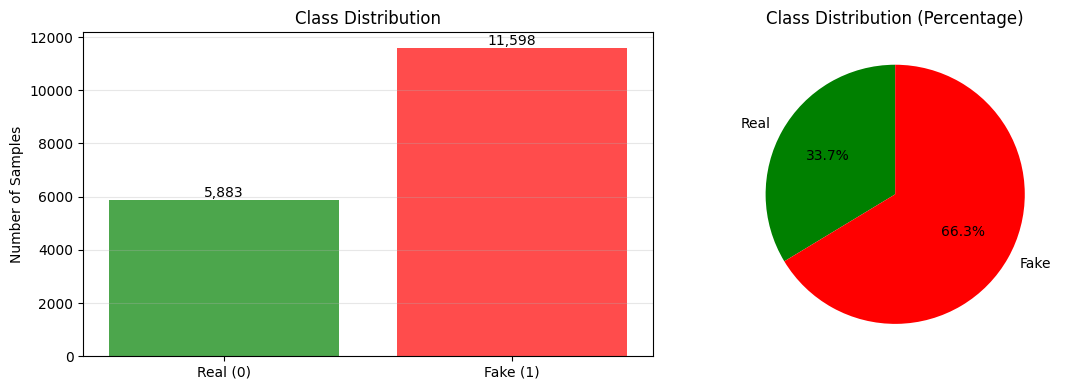

In [4]:
# Load metadata to calculate class distribution
print('=== Loading Metadata ===')

if os.path.exists(LABELS_CSV):
    df_labels = pd.read_csv(LABELS_CSV)
    print(f'Loaded {len(df_labels)} samples from {LABELS_CSV}')
    print(f'\nDataFrame shape: {df_labels.shape}')
    print(f'Columns: {list(df_labels.columns)}')
    print(f'\nFirst few rows:')
    display(df_labels.head())
    
    # Calculate class distribution
    print('\n=== Class Distribution ===')
    class_counts = df_labels['label'].value_counts().sort_index()
    print(f'Class 0 (Real): {class_counts[0]:,} samples ({class_counts[0]/len(df_labels)*100:.2f}%)')
    print(f'Class 1 (Fake): {class_counts[1]:,} samples ({class_counts[1]/len(df_labels)*100:.2f}%)')
    print(f'Total samples: {len(df_labels):,}')
    print(f'Imbalance ratio (Fake:Real): {class_counts[1]/class_counts[0]:.2f}:1')
    
    # Compute class weights for balanced training
    print('\n=== Computing Class Weights ===')
    labels = df_labels['label'].values
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    
    # Create class weight dictionary
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
    
    print('Class weights (balanced):')
    for class_id, weight in class_weights.items():
        class_name = 'Real' if class_id == 0 else 'Fake'
        print(f'  Class {class_id} ({class_name}): {weight:.4f}')
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot
    axes[0].bar(['Real (0)', 'Fake (1)'], class_counts.values, color=['green', 'red'], alpha=0.7)
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Class Distribution')
    axes[0].grid(axis='y', alpha=0.3)
    for i, count in enumerate(class_counts.values):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom')
    
    # Pie chart
    axes[1].pie(class_counts.values, labels=['Real', 'Fake'], autopct='%1.1f%%',
                colors=['green', 'red'], startangle=90)
    axes[1].set_title('Class Distribution (Percentage)')
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, 'class_distribution.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'\nClass distribution plot saved to: {plot_path}')
    plt.show()
    
else:
    print(f'ERROR: Labels CSV not found at {LABELS_CSV}')
    print('Please ensure the metadata file exists before proceeding.')


## Data Loading & Splits
Collect image paths from CelebDF, then build train/val/test splits per dataset.

In [5]:
print('=== Creating Train/Val/Test Splits ===')

# Construct full file paths
if 'filepath' not in df_labels.columns:
    print('ERROR: "filepath" column not found in labels CSV')
    print(f'Available columns: {list(df_labels.columns)}')
else:
    # Check if paths are absolute
    sample_path = df_labels['filepath'].iloc[0]
    print(f'Sample filepath from CSV: {sample_path}')
    
    if not os.path.isabs(sample_path):
        print(f'Converting relative paths to absolute paths...')
        
        # The CSV has paths like: output/images/celebdf/real/filename.jpg
        # We need to replace 'output' with DATA_ROOT
        df_labels['filepath'] = df_labels['filepath'].apply(
            lambda x: os.path.join(DATA_ROOT, x.replace('output/', '').replace('output\\', ''))
            if x.startswith('output') else os.path.join(DATA_ROOT, x)
        )
        
        print(f'Sample absolute path: {df_labels["filepath"].iloc[0]}')
    
    # Verify files exist
    print('\nVerifying file paths...')
    existing_files = df_labels['filepath'].apply(os.path.exists)
    num_existing = existing_files.sum()
    print(f'Files found: {num_existing}/{len(df_labels)} ({num_existing/len(df_labels)*100:.1f}%)')
    
    if num_existing == 0:
        print('\n❌ ERROR: No image files found!')
        print(f'\nExpected directory structure:')
        print(f'  {DATA_ROOT}/images/celebdf/real/')
        print(f'  {DATA_ROOT}/images/celebdf/synthesis/')
        print(f'\nSample expected path: {df_labels["filepath"].iloc[0]}')
        print(f'File exists: {os.path.exists(df_labels["filepath"].iloc[0])}')
        
        # Check if directory exists
        sample_dir = os.path.dirname(df_labels["filepath"].iloc[0])
        print(f'\nDirectory exists: {os.path.exists(sample_dir)}')
        if os.path.exists(sample_dir):
            print(f'Files in directory: {len(os.listdir(sample_dir))}')
    elif num_existing < len(df_labels):
        print(f'⚠️ WARNING: {len(df_labels) - num_existing} files are missing')
        # Filter to only existing files
        df_labels = df_labels[existing_files].reset_index(drop=True)
        print(f'✓ Proceeding with {len(df_labels)} existing files')
    else:
        print(f'✓ All files verified successfully!')

# Create stratified splits
train_df, temp_df = train_test_split(
    df_labels,
    test_size=(CONFIG['val_split'] + CONFIG['test_split']),
    stratify=df_labels['label'],
    random_state=CONFIG['random_state']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=CONFIG['test_split'] / (CONFIG['val_split'] + CONFIG['test_split']),
    stratify=temp_df['label'],
    random_state=CONFIG['random_state']
)

print(f'Train set: {len(train_df):,} samples')
print(f'  Real: {(train_df["label"]==0).sum():,} ({(train_df["label"]==0).sum()/len(train_df)*100:.1f}%)')
print(f'  Fake: {(train_df["label"]==1).sum():,} ({(train_df["label"]==1).sum()/len(train_df)*100:.1f}%)')

print(f'\nValidation set: {len(val_df):,} samples')
print(f'  Real: {(val_df["label"]==0).sum():,} ({(val_df["label"]==0).sum()/len(val_df)*100:.1f}%)')
print(f'  Fake: {(val_df["label"]==1).sum():,} ({(val_df["label"]==1).sum()/len(val_df)*100:.1f}%)')

print(f'\nTest set: {len(test_df):,} samples')
print(f'  Real: {(test_df["label"]==0).sum():,} ({(test_df["label"]==0).sum()/len(test_df)*100:.1f}%)')
print(f'  Fake: {(test_df["label"]==1).sum():,} ({(test_df["label"]==1).sum()/len(test_df)*100:.1f}%)')


def create_data_generators(train_df, val_df, test_df, img_size, batch_size):
    """
    Create ImageDataGenerator instances for train, validation, and test sets.
    
    Args:
        train_df: Training dataframe with 'filepath' and 'label' columns
        val_df: Validation dataframe
        test_df: Test dataframe
        img_size: Target image size for resizing
        batch_size: Batch size for generators
    
    Returns:
        train_gen, val_gen, test_gen: Data generators
    """
    # Training data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Validation and test data (only rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Prepare dataframes
    train_df_gen = train_df.copy()
    val_df_gen = val_df.copy()
    test_df_gen = test_df.copy()
    
    # Ensure labels are strings for flow_from_dataframe
    train_df_gen['label'] = train_df_gen['label'].astype(str)
    val_df_gen['label'] = val_df_gen['label'].astype(str)
    test_df_gen['label'] = test_df_gen['label'].astype(str)
    
    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df_gen,
        x_col='filepath',
        y_col='label',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=CONFIG['random_state']
    )
    
    val_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df_gen,
        x_col='filepath',
        y_col='label',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df_gen,
        x_col='filepath',
        y_col='label',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator


print('\n=== Creating Data Generators ===')

# Create generators for ResNet50 (224x224)
print(f'\nResNet50 generators (image size: {CONFIG["resnet50"]["img_size"]}x{CONFIG["resnet50"]["img_size"]}):')
train_gen_resnet, val_gen_resnet, test_gen_resnet = create_data_generators(
    train_df, val_df, test_df,
    img_size=CONFIG['resnet50']['img_size'],
    batch_size=CONFIG['resnet50']['batch_size']
)

# Create generators for EfficientNetB7 (380x380)
print(f'\nEfficientNetB7 generators (image size: {CONFIG["efficientnetb7"]["img_size"]}x{CONFIG["efficientnetb7"]["img_size"]}):')
train_gen_effnet, val_gen_effnet, test_gen_effnet = create_data_generators(
    train_df, val_df, test_df,
    img_size=CONFIG['efficientnetb7']['img_size'],
    batch_size=CONFIG['efficientnetb7']['batch_size']
)

print('\nData generators created successfully!')
print(f'ResNet50 - Train batches: {len(train_gen_resnet)}, Val batches: {len(val_gen_resnet)}, Test batches: {len(test_gen_resnet)}')
print(f'EfficientNetB7 - Train batches: {len(train_gen_effnet)}, Val batches: {len(val_gen_effnet)}, Test batches: {len(test_gen_effnet)}')


=== Creating Train/Val/Test Splits ===
Sample filepath from CSV: output/images/celebdf/real/id49_0006_0000.jpg
Converting relative paths to absolute paths...
Sample absolute path: /kaggle/input/celeb-df-images/output/images/celebdf/real/id49_0006_0000.jpg

Verifying file paths...
Files found: 17481/17481 (100.0%)
✓ All files verified successfully!
Train set: 12,236 samples
  Real: 4,118 (33.7%)
  Fake: 8,118 (66.3%)

Validation set: 2,622 samples
  Real: 882 (33.6%)
  Fake: 1,740 (66.4%)

Test set: 2,623 samples
  Real: 883 (33.7%)
  Fake: 1,740 (66.3%)

=== Creating Data Generators ===

ResNet50 generators (image size: 224x224):
Found 12236 validated image filenames belonging to 2 classes.
Found 2622 validated image filenames belonging to 2 classes.
Found 2623 validated image filenames belonging to 2 classes.

EfficientNetB7 generators (image size: 380x380):
Found 12236 validated image filenames belonging to 2 classes.
Found 2622 validated image filenames belonging to 2 classes.
Found

## Training per Dataset
Train both EfficientNetB7 and ResNet50 on each dataset with two-phase training (head-only then fine-tuning).


TRAINING RESNET50 MODEL

Training ResNet50

--- PHASE 1: Training classification head (backbone frozen) ---
Model built with 24,768,385 total parameters
Trainable parameters in Phase 1: 1,180,673

Starting Phase 1 training for 10 epochs...
Epoch 1/10


I0000 00:00:1764513714.988697      63 service.cc:148] XLA service 0x7e507c003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764513714.989324      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764513714.989346      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764513716.567123      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/383 ━━━━━━━━━━━━━━━━━━━━ 1:33:51 15s/step - accuracy: 0.4375 - auc: 0.5687 - loss: 0.9563 - precision: 0.6667 - recall: 0.2000

I0000 00:00:1764513722.084867      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5040 - auc: 0.5102 - loss: 0.7460 - precision: 0.6629 - recall: 0.5087
Epoch 1: val_loss improved from inf to 0.69382, saving model to /kaggle/working/models/ResNet50_phase1_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 207s 504ms/step - accuracy: 0.5040 - auc: 0.5101 - loss: 0.7459 - precision: 0.6629 - recall: 0.5088 - val_accuracy: 0.3364 - val_auc: 0.5000 - val_loss: 0.6938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.4050 - auc: 0.4975 - loss: 0.6968 - precision: 0.6487 - recall: 0.2009
Epoch 2: val_loss did not improve from 0.69382
383/383 ━━━━━━━━━━━━━━━━━━━━ 161s 419ms/step - accuracy: 0.4051 - auc: 0.4975 - loss: 0.6968 - precision: 0.6487 - recall: 0.2012 - val_accuracy: 0.3364 - val_auc: 0.5000 - val_loss: 0.6939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4504 - auc: 0.4941 - loss: 0.6943 - precision: 0.6593 - recall: 0.3477
Epoch 3: val_loss improved from 0.69382 to 0.69319, saving model to /kaggle/working/models/ResNet50_phase1_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 160s 417ms/step - accuracy: 0.4506 - auc: 0.4941 - loss: 0.6943 - precision: 0.6593 - recall: 0.3481 - val_accuracy: 0.3364 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6429 - auc: 0.5016 - loss: 0.6878 - precision: 0.6741 - recall: 0.9139
Epoch 4: val_loss did not improve from 0.69319
383/383 ━━━━━━━━━━━━━━━━━━━━ 160s 418ms/step - accuracy: 0.6428 - auc: 0.5016 - loss: 0.6878 - precision: 0.6741 - recall: 0.9138 - val_accuracy: 0.3364 - val_auc: 0.5000 - val_loss: 0.6971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.3761 - auc: 0.4902 - loss: 0.6913 - precision: 0.6353 - recall: 0.1304
Epoch 5: val_loss did not improve from 0.69319
383/383 ━━━━━━━━━━━━━━━━━━━━ 160s 418ms/step - accuracy: 0.3761 - auc: 0.4903 - loss: 0.6913 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 158s 413ms/step - accuracy: 0.4381 - auc: 0.4955 - loss: 0.6940 - precision: 0.6607 - recall: 0.3109 - val_accuracy: 0.6636 - val_auc: 0.5000 - val_loss: 0.6926 - val_precision: 0.6636 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5571 - auc: 0.4953 - loss: 0.6918 - precision: 0.6707 - recall: 0.6566
Epoch 7: val_loss did not improve from 0.69264
383/383 ━━━━━━━━━━━━━━━━━━━━ 160s 416ms/step - accuracy: 0.5569 - auc: 0.4953 - loss: 0.6918 - precision: 0.6707 - recall: 0.6561 - val_accuracy: 0.3364 - val_auc: 0.5000 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5501 - auc: 0.4980 - loss: 0.6905 - precision: 0.6683 - recall: 0.6504
Epoch 8: val_loss did not improve from 0.69264
383/383 ━━━━━━━━━━━━━━━━━━━━ 158s 411ms/step - accuracy: 0.5500 - auc: 0.4980 - loss: 0.6905 - precisi

383/383 ━━━━━━━━━━━━━━━━━━━━ 257s 517ms/step - accuracy: 0.5078 - auc: 0.5384 - loss: 0.7168 - precision: 0.6923 - recall: 0.4586 - val_accuracy: 0.6602 - val_auc: 0.5830 - val_loss: 0.6515 - val_precision: 0.6661 - val_recall: 0.9782 - learning_rate: 1.0000e-05
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7360 - auc: 0.8080 - loss: 0.5354 - precision: 0.8464 - recall: 0.7364
Epoch 2: val_loss improved from 0.65147 to 0.64794, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 172s 447ms/step - accuracy: 0.7361 - auc: 0.8081 - loss: 0.5352 - precision: 0.8464 - recall: 0.7365 - val_accuracy: 0.6522 - val_auc: 0.5999 - val_loss: 0.6479 - val_precision: 0.6922 - val_recall: 0.8569 - learning_rate: 1.0000e-05
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8523 - auc: 0.9287 - loss: 0.3430 - precision: 0.9179 - recall: 0.8535
Epoch 3: val_loss improved from 0.64794 to 0.26305, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 447ms/step - accuracy: 0.8523 - auc: 0.9287 - loss: 0.3429 - precision: 0.9180 - recall: 0.8535 - val_accuracy: 0.8902 - val_auc: 0.9562 - val_loss: 0.2631 - val_precision: 0.8895 - val_recall: 0.9529 - learning_rate: 1.0000e-05
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8989 - auc: 0.9633 - loss: 0.2460 - precision: 0.9511 - recall: 0.8955
Epoch 4: val_loss improved from 0.26305 to 0.16872, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 172s 449ms/step - accuracy: 0.8989 - auc: 0.9633 - loss: 0.2460 - precision: 0.9511 - recall: 0.8956 - val_accuracy: 0.9302 - val_auc: 0.9876 - val_loss: 0.1687 - val_precision: 0.9826 - val_recall: 0.9109 - learning_rate: 1.0000e-05
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9191 - auc: 0.9746 - loss: 0.2041 - precision: 0.9622 - recall: 0.9145
Epoch 5: val_loss improved from 0.16872 to 0.11613, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 169s 441ms/step - accuracy: 0.9191 - auc: 0.9746 - loss: 0.2040 - precision: 0.9622 - recall: 0.9145 - val_accuracy: 0.9542 - val_auc: 0.9910 - val_loss: 0.1161 - val_precision: 0.9545 - val_recall: 0.9776 - learning_rate: 1.0000e-05
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9334 - auc: 0.9813 - loss: 0.1740 - precision: 0.9705 - recall: 0.9284
Epoch 6: val_loss improved from 0.11613 to 0.09666, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 173s 452ms/step - accuracy: 0.9334 - auc: 0.9813 - loss: 0.1740 - precision: 0.9705 - recall: 0.9284 - val_accuracy: 0.9630 - val_auc: 0.9934 - val_loss: 0.0967 - val_precision: 0.9633 - val_recall: 0.9816 - learning_rate: 1.0000e-05
Epoch 7/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9464 - auc: 0.9878 - loss: 0.1393 - precision: 0.9739 - recall: 0.9448
Epoch 7: val_loss improved from 0.09666 to 0.07978, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 176s 459ms/step - accuracy: 0.9464 - auc: 0.9878 - loss: 0.1393 - precision: 0.9739 - recall: 0.9448 - val_accuracy: 0.9687 - val_auc: 0.9957 - val_loss: 0.0798 - val_precision: 0.9842 - val_recall: 0.9684 - learning_rate: 1.0000e-05
Epoch 8/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9540 - auc: 0.9907 - loss: 0.1202 - precision: 0.9776 - recall: 0.9520
Epoch 8: val_loss did not improve from 0.07978
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 447ms/step - accuracy: 0.9540 - auc: 0.9907 - loss: 0.1202 - precision: 0.9776 - recall: 0.9520 - val_accuracy: 0.9584 - val_auc: 0.9943 - val_loss: 0.0923 - val_precision: 0.9533 - val_recall: 0.9856 - learning_rate: 1.0000e-05
Epoch 9/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9581 - auc: 0.9925 - loss: 0.1085 - precision: 0.9800 - recall: 0.9562
Epoch 9: val_loss improved from 0.07978 to 0.07592, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accuracy: 0.9581 - auc: 0.9925 - loss: 0.1085 - precision: 0.9800 - recall: 0.9562 - val_accuracy: 0.9729 - val_auc: 0.9950 - val_loss: 0.0759 - val_precision: 0.9766 - val_recall: 0.9828 - learning_rate: 1.0000e-05
Epoch 10/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9593 - auc: 0.9921 - loss: 0.1106 - precision: 0.9798 - recall: 0.9588
Epoch 10: val_loss improved from 0.07592 to 0.06160, saving model to /kaggle/working/models/ResNet50_phase2_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accuracy: 0.9593 - auc: 0.9921 - loss: 0.1106 - precision: 0.9798 - recall: 0.9588 - val_accuracy: 0.9783 - val_auc: 0.9968 - val_loss: 0.0616 - val_precision: 0.9856 - val_recall: 0.9816 - learning_rate: 1.0000e-05
Epoch 11/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9630 - auc: 0.9937 - loss: 0.0947 - precision: 0.9822 - recall: 0.9618
Epoch 11: val_loss did not improve from 0.06160
383/383 ━━━━━━━━━━━━━━━━━━━━ 170s 443ms/step - accuracy: 0.9630 - auc: 0.9937 - loss: 0.0947 - precision: 0.9822 - recall: 0.9618 - val_accuracy: 0.9748 - val_auc: 0.9973 - val_loss: 0.0641 - val_precision: 0.9734 - val_recall: 0.9891 - learning_rate: 1.0000e-05
Epoch 12/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9707 - auc: 0.9955 - loss: 0.0786 - precision: 0.9862 - recall: 0.9698
Epoch 12: val_loss did not improve from 0.06160
383/383 ━━━━━━━━━━━━━━━━━━━━ 170s 443ms/step - accuracy: 0.9707 - auc: 0.9955 - loss: 0.0786 - pre

383/383 ━━━━━━━━━━━━━━━━━━━━ 170s 443ms/step - accuracy: 0.9748 - auc: 0.9972 - loss: 0.0666 - precision: 0.9877 - recall: 0.9745 - val_accuracy: 0.9771 - val_auc: 0.9972 - val_loss: 0.0556 - val_precision: 0.9767 - val_recall: 0.9891 - learning_rate: 1.0000e-05
Epoch 14/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9752 - auc: 0.9969 - loss: 0.0659 - precision: 0.9877 - recall: 0.9746
Epoch 14: val_loss did not improve from 0.05563
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accuracy: 0.9752 - auc: 0.9969 - loss: 0.0659 - precision: 0.9877 - recall: 0.9746 - val_accuracy: 0.9775 - val_auc: 0.9974 - val_loss: 0.0659 - val_precision: 0.9976 - val_recall: 0.9684 - learning_rate: 1.0000e-05
Epoch 15/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9761 - auc: 0.9970 - loss: 0.0625 - precision: 0.9899 - recall: 0.9738
Epoch 15: val_loss did not improve from 0.05563
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 445ms/step - accuracy: 0.9761 - auc: 0.9970 - loss: 0.0625 - pre

383/383 ━━━━━━━━━━━━━━━━━━━━ 172s 449ms/step - accuracy: 0.9802 - auc: 0.9979 - loss: 0.0510 - precision: 0.9913 - recall: 0.9789 - val_accuracy: 0.9840 - val_auc: 0.9986 - val_loss: 0.0424 - val_precision: 0.9863 - val_recall: 0.9897 - learning_rate: 1.0000e-05
Epoch 17/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9802 - auc: 0.9983 - loss: 0.0491 - precision: 0.9917 - recall: 0.9788
Epoch 17: val_loss did not improve from 0.04238
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accuracy: 0.9802 - auc: 0.9983 - loss: 0.0491 - precision: 0.9917 - recall: 0.9788 - val_accuracy: 0.9855 - val_auc: 0.9981 - val_loss: 0.0453 - val_precision: 0.9908 - val_recall: 0.9874 - learning_rate: 1.0000e-05
Epoch 18/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9801 - auc: 0.9982 - loss: 0.0480 - precision: 0.9918 - recall: 0.9783
Epoch 18: val_loss did not improve from 0.04238
383/383 ━━━━━━━━━━━━━━━━━━━━ 170s 443ms/step - accuracy: 0.9801 - auc: 0.9982 - loss: 0.0480 - pre


Phase 2 complete!
Best val_loss: 0.0424
Best val_accuracy: 0.9855

Final model saved to: /kaggle/working/models/ResNet50_final.h5
Training history plot saved to: /kaggle/working/plots/ResNet50_training_history.png


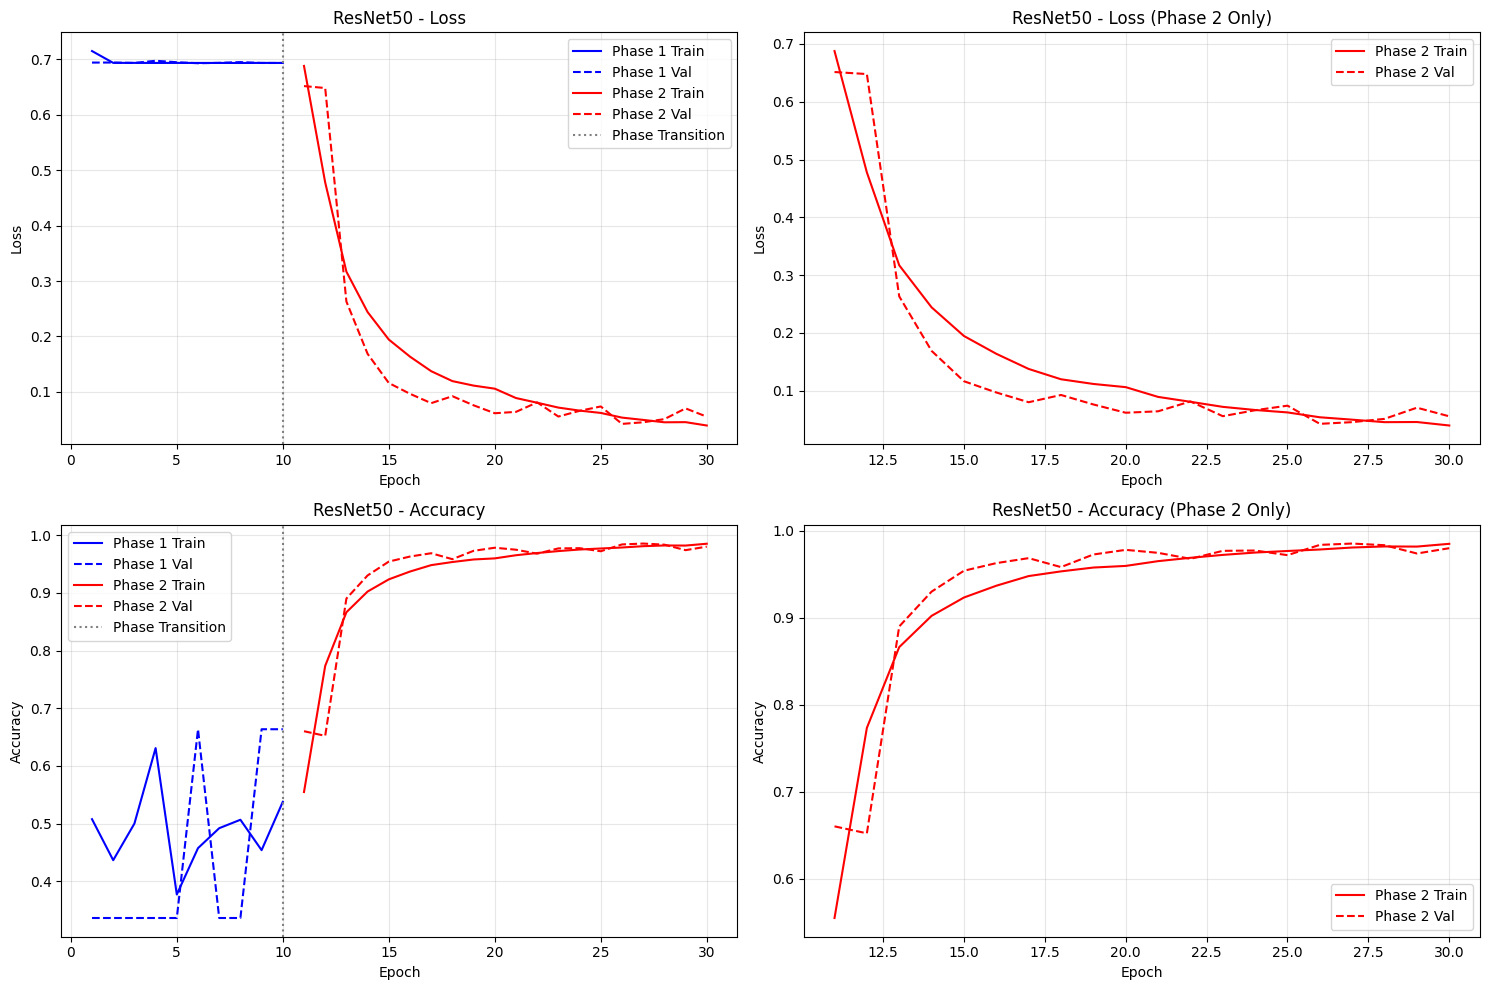


ResNet50 training complete. Model cleared from memory.


In [6]:
def train_model_two_phase(model_name, build_fn, train_gen, val_gen, config, class_weights):
    """
    Train a model using two-phase approach: head-only training, then fine-tuning.
    
    Args:
        model_name: Name of the model ('ResNet50' or 'EfficientNetB7')
        build_fn: Function to build the model
        train_gen: Training data generator
        val_gen: Validation data generator
        config: Model-specific configuration dictionary
        class_weights: Class weights for balanced training
    
    Returns:
        model: Trained model
        history_phase1: Training history from phase 1
        history_phase2: Training history from phase 2
    """
    print(f'\n{"="*80}')
    print(f'Training {model_name}')
    print(f'{"="*80}')
    
    # ========== PHASE 1: Train head only (frozen backbone) ==========
    print(f'\n--- PHASE 1: Training classification head (backbone frozen) ---')
    
    # Build model
    model = build_fn(
        img_size=config['img_size'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['phase1_lr']
    )
    
    print(f'Model built with {model.count_params():,} total parameters')
    
    # Count trainable parameters
    trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f'Trainable parameters in Phase 1: {trainable_count:,}')
    
    # Callbacks for Phase 1
    callbacks_phase1 = [
        ModelCheckpoint(
            os.path.join(MODELS_DIR, f'{model_name}_phase1_best.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['early_stopping_patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=CONFIG['reduce_lr_factor'],
            patience=CONFIG['reduce_lr_patience'],
            min_lr=CONFIG['reduce_lr_min'],
            verbose=1
        )
    ]
    
    # Train Phase 1
    print(f'\nStarting Phase 1 training for {config["phase1_epochs"]} epochs...')
    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config['phase1_epochs'],
        class_weight=class_weights,
        callbacks=callbacks_phase1,
        verbose=1
    )
    
    print(f'\nPhase 1 complete!')
    print(f'Best val_loss: {min(history_phase1.history["val_loss"]):.4f}')
    print(f'Best val_accuracy: {max(history_phase1.history["val_accuracy"]):.4f}')
    
    # ========== PHASE 2: Fine-tune entire model ==========
    print(f'\n--- PHASE 2: Fine-tuning entire model ---')
    
    # Unfreeze the base model
    model.layers[1].trainable = True  # layers[1] is the base model (ResNet50 or EfficientNetB7)
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=config['phase2_lr']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f'Trainable parameters in Phase 2: {trainable_count:,}')
    
    # Callbacks for Phase 2
    callbacks_phase2 = [
        ModelCheckpoint(
            os.path.join(MODELS_DIR, f'{model_name}_phase2_best.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['early_stopping_patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=CONFIG['reduce_lr_factor'],
            patience=CONFIG['reduce_lr_patience'],
            min_lr=CONFIG['reduce_lr_min'],
            verbose=1
        )
    ]
    
    # Train Phase 2
    print(f'\nStarting Phase 2 training for {config["phase2_epochs"]} epochs...')
    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config['phase2_epochs'],
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    print(f'\nPhase 2 complete!')
    print(f'Best val_loss: {min(history_phase2.history["val_loss"]):.4f}')
    print(f'Best val_accuracy: {max(history_phase2.history["val_accuracy"]):.4f}')
    
    # Save final model
    final_model_path = os.path.join(MODELS_DIR, f'{model_name}_final.h5')
    model.save(final_model_path)
    print(f'\nFinal model saved to: {final_model_path}')
    
    return model, history_phase1, history_phase2


def plot_training_history(history_phase1, history_phase2, model_name):
    """Plot training history for both phases."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Combine histories
    metrics = ['loss', 'accuracy']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx, 0]
        # Phase 1
        epochs_p1 = range(1, len(history_phase1.history[metric]) + 1)
        ax.plot(epochs_p1, history_phase1.history[metric], 'b-', label=f'Phase 1 Train')
        ax.plot(epochs_p1, history_phase1.history[f'val_{metric}'], 'b--', label=f'Phase 1 Val')
        
        # Phase 2
        offset = len(epochs_p1)
        epochs_p2 = range(offset + 1, offset + len(history_phase2.history[metric]) + 1)
        ax.plot(epochs_p2, history_phase2.history[metric], 'r-', label=f'Phase 2 Train')
        ax.plot(epochs_p2, history_phase2.history[f'val_{metric}'], 'r--', label=f'Phase 2 Val')
        
        ax.axvline(x=offset, color='gray', linestyle=':', label='Phase Transition')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{model_name} - {metric.capitalize()}')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # Zoomed view for phase 2
        ax2 = axes[idx, 1]
        ax2.plot(epochs_p2, history_phase2.history[metric], 'r-', label=f'Phase 2 Train')
        ax2.plot(epochs_p2, history_phase2.history[f'val_{metric}'], 'r--', label=f'Phase 2 Val')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel(metric.capitalize())
        ax2.set_title(f'{model_name} - {metric.capitalize()} (Phase 2 Only)')
        ax2.legend()
        ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, f'{model_name}_training_history.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'Training history plot saved to: {plot_path}')
    plt.show()


# ========== TRAIN RESNET50 ==========
print('\n' + '='*80)
print('TRAINING RESNET50 MODEL')
print('='*80)

model_resnet50, hist_resnet_p1, hist_resnet_p2 = train_model_two_phase(
    model_name='ResNet50',
    build_fn=build_resnet50_model,
    train_gen=train_gen_resnet,
    val_gen=val_gen_resnet,
    config=CONFIG['resnet50'],
    class_weights=class_weights
)

# Plot training history
plot_training_history(hist_resnet_p1, hist_resnet_p2, 'ResNet50')

# Clear memory
del model_resnet50
tf.keras.backend.clear_session()
print('\nResNet50 training complete. Model cleared from memory.')



TRAINING EFFICIENTNETB7 MODEL

Training EfficientNetB7

--- PHASE 1: Training classification head (backbone frozen) ---
Model built with 65,540,504 total parameters
Trainable parameters in Phase 1: 1,442,817

Starting Phase 1 training for 10 epochs...
Epoch 1/10


E0000 00:00:1764518920.933653      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764518921.137798      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


123/765 ━━━━━━━━━━━━━━━━━━━━ 6:12 580ms/step - accuracy: 0.5024 - auc: 0.4991 - loss: 0.7749 - precision: 0.6537 - recall: 0.5044

E0000 00:00:1764519031.443010      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764519031.630208      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.4982 - auc: 0.5075 - loss: 0.7263 - precision: 0.6643 - recall: 0.4769

E0000 00:00:1764519519.265724      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764519519.461351      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.69022, saving model to /kaggle/working/models/EfficientNetB7_phase1_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 659s 765ms/step - accuracy: 0.4983 - auc: 0.5074 - loss: 0.7262 - precision: 0.6643 - recall: 0.4770 - val_accuracy: 0.6636 - val_auc: 0.5000 - val_loss: 0.6902 - val_precision: 0.6636 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.5596 - auc: 0.4932 - loss: 0.6944 - precision: 0.6625 - recall: 0.6837
Epoch 2: val_loss did not improve from 0.69022
765/765 ━━━━━━━━━━━━━━━━━━━━ 515s 673ms/step - accuracy: 0.5595 - auc: 0.4932 - loss: 0.6944 - precision: 0.6625 - recall: 0.6835 - val_accuracy: 0.6636 - val_auc: 0.5000 - val_loss: 0.6904 - val_precision: 0.6636 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5095 - auc: 0.4860 - loss: 0.6956 - precision: 0.6523 - recall: 0.5513
Epoch 3: val_loss did not improve from 0.69022
765/765 ━━━━━━━━━━━━━━━━━━━━ 507s 662ms/step - accuracy: 0.5095 - auc: 0.4860 - loss: 0.6956 - precision: 0.65

E0000 00:00:1764522251.996604      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764522252.270750      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-30 17:04:13.718709: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[48,288,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,288,95,95]{3,2,1,0}, f32[16,48,95,95]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-30 17:04:13.879860: E externa

678/765 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.5575 - auc: 0.5241 - loss: 0.7536 - precision: 0.6690 - recall: 0.6437

E0000 00:00:1764523425.433435      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764523425.674152      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764523427.570124      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764523427.748171      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764523428.450029      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5570 - auc: 0.5261 - loss: 0.7498 - precision: 0.6710 - recall: 0.6385
Epoch 1: val_loss improved from inf to 0.63122, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1638s 2s/step - accuracy: 0.5570 - auc: 0.5262 - loss: 0.7498 - precision: 0.6710 - recall: 0.6384 - val_accuracy: 0.7121 - val_auc: 0.7324 - val_loss: 0.6312 - val_precision: 0.7337 - val_recall: 0.8885 - learning_rate: 1.0000e-05
Epoch 2/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6294 - auc: 0.6749 - loss: 0.6514 - precision: 0.7631 - recall: 0.6360
Epoch 2: val_loss improved from 0.63122 to 0.36008, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1275s 2s/step - accuracy: 0.6295 - auc: 0.6750 - loss: 0.6513 - precision: 0.7632 - recall: 0.6361 - val_accuracy: 0.8505 - val_auc: 0.9257 - val_loss: 0.3601 - val_precision: 0.9218 - val_recall: 0.8466 - learning_rate: 1.0000e-05
Epoch 3/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8101 - auc: 0.8993 - loss: 0.4001 - precision: 0.9157 - recall: 0.7880
Epoch 3: val_loss improved from 0.36008 to 0.21084, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1275s 2s/step - accuracy: 0.8102 - auc: 0.8993 - loss: 0.4000 - precision: 0.9157 - recall: 0.7881 - val_accuracy: 0.9153 - val_auc: 0.9755 - val_loss: 0.2108 - val_precision: 0.9600 - val_recall: 0.9103 - learning_rate: 1.0000e-05
Epoch 4/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8783 - auc: 0.9508 - loss: 0.2850 - precision: 0.9428 - recall: 0.8705
Epoch 4: val_loss improved from 0.21084 to 0.15858, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.8783 - auc: 0.9508 - loss: 0.2849 - precision: 0.9428 - recall: 0.8705 - val_accuracy: 0.9382 - val_auc: 0.9891 - val_loss: 0.1586 - val_precision: 0.9829 - val_recall: 0.9230 - learning_rate: 1.0000e-05
Epoch 5/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9172 - auc: 0.9732 - loss: 0.2125 - precision: 0.9556 - recall: 0.9173
Epoch 5: val_loss improved from 0.15858 to 0.11436, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.9172 - auc: 0.9732 - loss: 0.2125 - precision: 0.9556 - recall: 0.9173 - val_accuracy: 0.9546 - val_auc: 0.9937 - val_loss: 0.1144 - val_precision: 0.9891 - val_recall: 0.9420 - learning_rate: 1.0000e-05
Epoch 6/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9264 - auc: 0.9818 - loss: 0.1727 - precision: 0.9656 - recall: 0.9211
Epoch 6: val_loss did not improve from 0.11436
765/765 ━━━━━━━━━━━━━━━━━━━━ 1269s 2s/step - accuracy: 0.9264 - auc: 0.9818 - loss: 0.1726 - precision: 0.9656 - recall: 0.9211 - val_accuracy: 0.9458 - val_auc: 0.9944 - val_loss: 0.1320 - val_precision: 0.9926 - val_recall: 0.9253 - learning_rate: 1.0000e-05
Epoch 7/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9426 - auc: 0.9865 - loss: 0.1476 - precision: 0.9721 - recall: 0.9403
Epoch 7: val_loss improved from 0.11436 to 0.10250, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1276s 2s/step - accuracy: 0.9426 - auc: 0.9865 - loss: 0.1476 - precision: 0.9721 - recall: 0.9403 - val_accuracy: 0.9603 - val_auc: 0.9952 - val_loss: 0.1025 - val_precision: 0.9910 - val_recall: 0.9489 - learning_rate: 1.0000e-05
Epoch 8/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9478 - auc: 0.9902 - loss: 0.1260 - precision: 0.9783 - recall: 0.9430
Epoch 8: val_loss improved from 0.10250 to 0.07744, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.9478 - auc: 0.9902 - loss: 0.1260 - precision: 0.9783 - recall: 0.9430 - val_accuracy: 0.9699 - val_auc: 0.9975 - val_loss: 0.0774 - val_precision: 0.9929 - val_recall: 0.9615 - learning_rate: 1.0000e-05
Epoch 9/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9604 - auc: 0.9936 - loss: 0.0994 - precision: 0.9845 - recall: 0.9556
Epoch 9: val_loss did not improve from 0.07744
765/765 ━━━━━━━━━━━━━━━━━━━━ 1268s 2s/step - accuracy: 0.9604 - auc: 0.9936 - loss: 0.0994 - precision: 0.9845 - recall: 0.9556 - val_accuracy: 0.9348 - val_auc: 0.9946 - val_loss: 0.1637 - val_precision: 0.9931 - val_recall: 0.9080 - learning_rate: 1.0000e-05
Epoch 10/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9644 - auc: 0.9947 - loss: 0.0931 - precision: 0.9824 - recall: 0.9625
Epoch 10: val_loss improved from 0.07744 to 0.06354, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.9644 - auc: 0.9947 - loss: 0.0931 - precision: 0.9824 - recall: 0.9625 - val_accuracy: 0.9771 - val_auc: 0.9965 - val_loss: 0.0635 - val_precision: 0.9895 - val_recall: 0.9759 - learning_rate: 1.0000e-05
Epoch 11/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9750 - auc: 0.9967 - loss: 0.0717 - precision: 0.9893 - recall: 0.9728
Epoch 11: val_loss improved from 0.06354 to 0.04580, saving model to /kaggle/working/models/EfficientNetB7_phase2_best.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.9749 - auc: 0.9967 - loss: 0.0717 - precision: 0.9893 - recall: 0.9728 - val_accuracy: 0.9836 - val_auc: 0.9977 - val_loss: 0.0458 - val_precision: 0.9885 - val_recall: 0.9868 - learning_rate: 1.0000e-05
Epoch 12/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9753 - auc: 0.9969 - loss: 0.0664 - precision: 0.9888 - recall: 0.9741
Epoch 12: val_loss did not improve from 0.04580
765/765 ━━━━━━━━━━━━━━━━━━━━ 1270s 2s/step - accuracy: 0.9753 - auc: 0.9969 - loss: 0.0664 - precision: 0.9888 - recall: 0.9741 - val_accuracy: 0.9733 - val_auc: 0.9979 - val_loss: 0.0674 - val_precision: 0.9958 - val_recall: 0.9638 - learning_rate: 1.0000e-05
Epoch 13/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9743 - auc: 0.9972 - loss: 0.0632 - precision: 0.9918 - recall: 0.9699
Epoch 13: val_loss did not improve from 0.04580
765/765 ━━━━━━━━━━━━━━━━━━━━ 1269s 2s/step - accuracy: 0.9744 - auc: 0.9972 - loss: 0.0632 - precision: 0.99


Phase 2 complete!
Best val_loss: 0.0458
Best val_accuracy: 0.9836

Final model saved to: /kaggle/working/models/EfficientNetB7_final.h5
Training history plot saved to: /kaggle/working/plots/EfficientNetB7_training_history.png


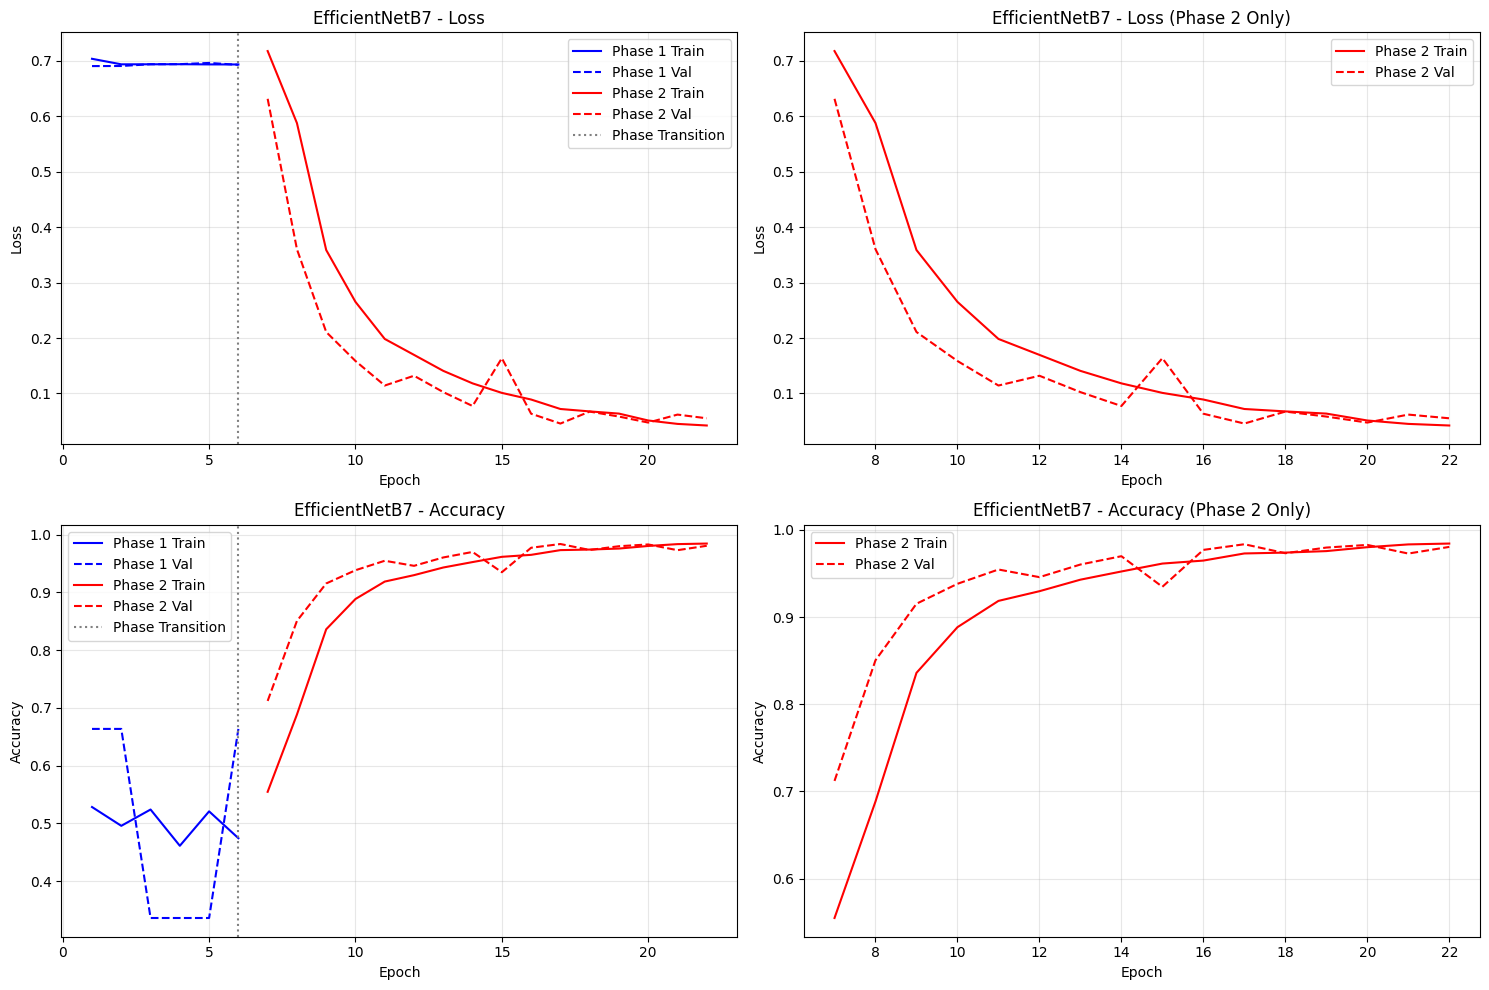


EfficientNetB7 training complete. Model cleared from memory.

ALL TRAINING COMPLETE!

Trained models saved in: /kaggle/working/models
Models available:
  - ResNet50_phase1_best.h5
  - ResNet50_phase2_best.h5
  - ResNet50_final.h5
  - EfficientNetB7_phase1_best.h5
  - EfficientNetB7_phase2_best.h5
  - EfficientNetB7_final.h5


In [7]:
# ========== TRAIN EFFICIENTNETB7 ==========
print('\n' + '='*80)
print('TRAINING EFFICIENTNETB7 MODEL')
print('='*80)

model_efficientnetb7, hist_effnet_p1, hist_effnet_p2 = train_model_two_phase(
    model_name='EfficientNetB7',
    build_fn=build_efficientnetb7_model,
    train_gen=train_gen_effnet,
    val_gen=val_gen_effnet,
    config=CONFIG['efficientnetb7'],
    class_weights=class_weights
)

# Plot training history
plot_training_history(hist_effnet_p1, hist_effnet_p2, 'EfficientNetB7')

# Clear memory
del model_efficientnetb7
tf.keras.backend.clear_session()
print('\nEfficientNetB7 training complete. Model cleared from memory.')

print('\n' + '='*80)
print('ALL TRAINING COMPLETE!')
print('='*80)
print(f'\nTrained models saved in: {MODELS_DIR}')
print('Models available:')
print('  - ResNet50_phase1_best.h5')
print('  - ResNet50_phase2_best.h5')
print('  - ResNet50_final.h5')
print('  - EfficientNetB7_phase1_best.h5')
print('  - EfficientNetB7_phase2_best.h5')
print('  - EfficientNetB7_final.h5')


## Evaluation & Model Comparison
Evaluate each model on test splits and compare EfficientNetB7 vs ResNet50 performance.


MODEL EVALUATION ON TEST SET

Evaluating ResNet50
Loading model from: /kaggle/working/models/ResNet50_final.h5


Generating predictions on test set...
82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step

=== ResNet50 Test Results ===
Accuracy:  0.9790
Precision: 0.9817
Recall:    0.9868
F1-Score:  0.9842
AUC-ROC:   0.9977

Confusion Matrix:
[[ 851   32]
 [  23 1717]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.96      0.97       883
        Fake       0.98      0.99      0.98      1740

    accuracy                           0.98      2623
   macro avg       0.98      0.98      0.98      2623
weighted avg       0.98      0.98      0.98      2623

Confusion matrix saved to: /kaggle/working/plots/ResNet50_confusion_matrix.png


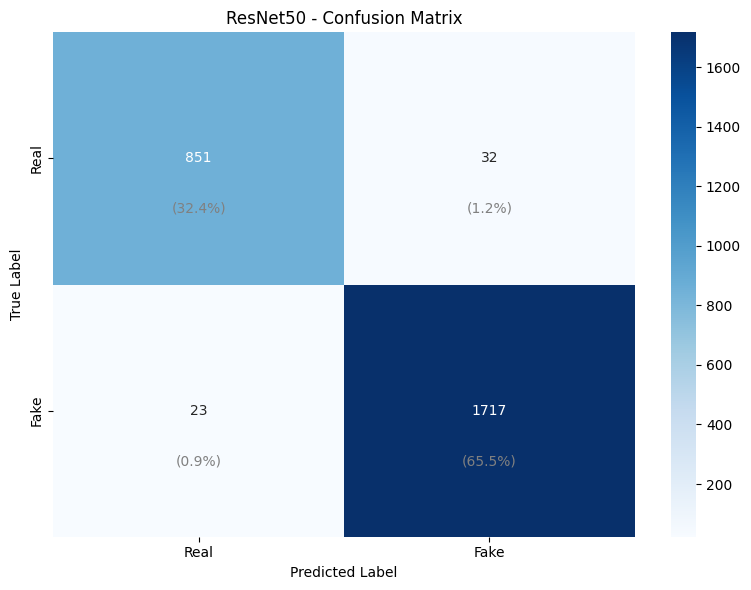


Evaluating EfficientNetB7
Loading model from: /kaggle/working/models/EfficientNetB7_final.h5


Generating predictions on test set...
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step

E0000 00:00:1764542946.969074      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764542947.168197      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


164/164 ━━━━━━━━━━━━━━━━━━━━ 100s 530ms/step

=== EfficientNetB7 Test Results ===
Accuracy:  0.6634
Precision: 0.6634
Recall:    1.0000
F1-Score:  0.7976
AUC-ROC:   0.5008

Confusion Matrix:
[[   0  883]
 [   0 1740]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       883
        Fake       0.66      1.00      0.80      1740

    accuracy                           0.66      2623
   macro avg       0.33      0.50      0.40      2623
weighted avg       0.44      0.66      0.53      2623

Confusion matrix saved to: /kaggle/working/plots/EfficientNetB7_confusion_matrix.png


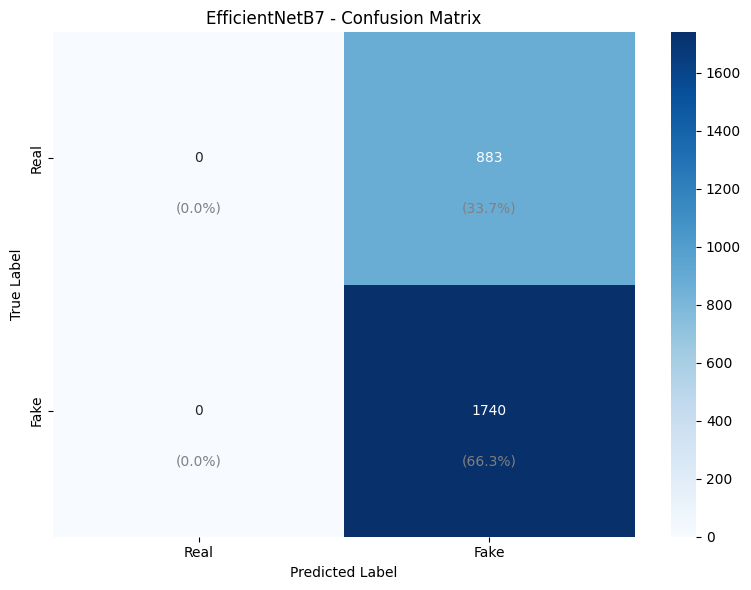


MODEL COMPARISON
ROC curves saved to: /kaggle/working/plots/roc_curves_comparison.png


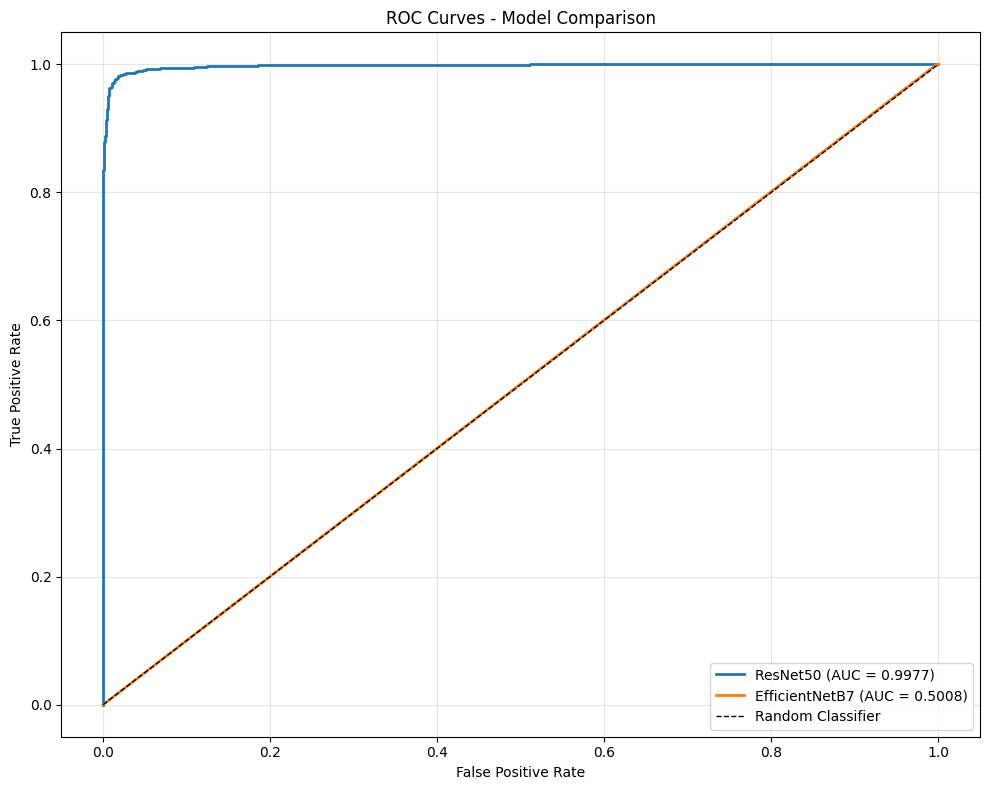

Metrics comparison saved to: /kaggle/working/plots/metrics_comparison.png


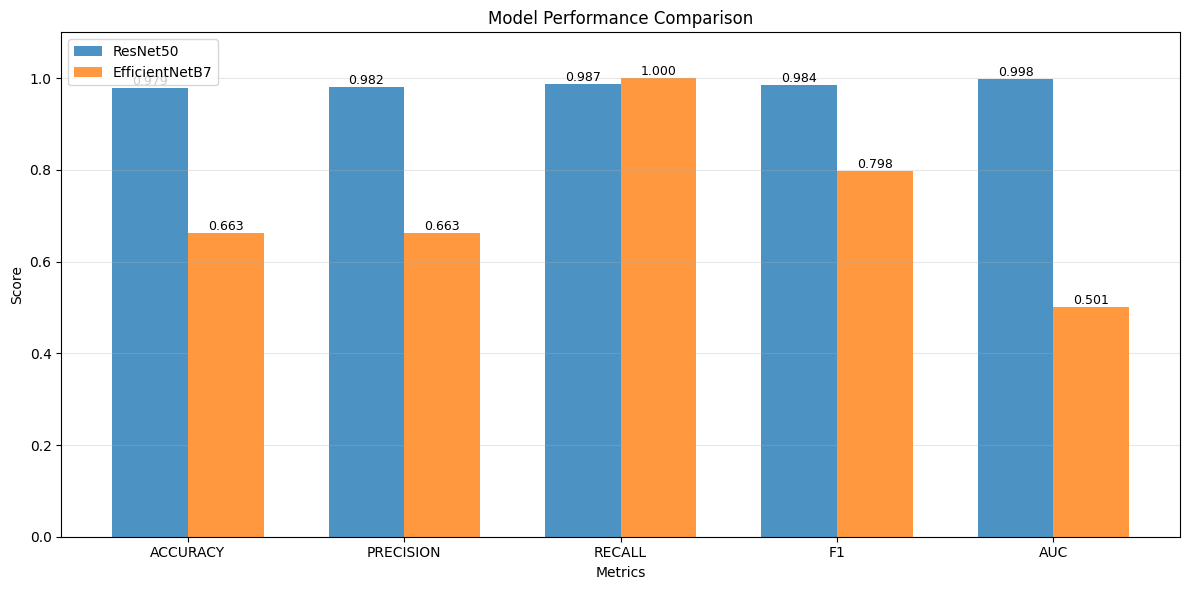


=== Summary Table ===


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,ResNet50,0.9790,0.9817,0.9868,0.9842,0.9977
1,EfficientNetB7,0.6634,0.6634,1.0000,0.7976,0.5008



🏆 Best Model (by F1-Score): ResNet50
   F1-Score: 0.9842
   AUC-ROC: 0.9977


In [8]:
def evaluate_model(model_path, test_gen, model_name):
    """
    Evaluate a trained model on the test set.
    
    Args:
        model_path: Path to the saved model
        test_gen: Test data generator
        model_name: Name of the model for reporting
    
    Returns:
        Dictionary with evaluation metrics and predictions
    """
    print(f'\n{"="*80}')
    print(f'Evaluating {model_name}')
    print(f'{"="*80}')
    
    # Load model
    print(f'Loading model from: {model_path}')
    model = keras.models.load_model(model_path)
    
    # Get predictions
    print('Generating predictions on test set...')
    test_gen.reset()
    y_pred_prob = model.predict(test_gen, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = test_gen.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f'\n=== {model_name} Test Results ===')
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'AUC-ROC:   {auc_score:.4f}')
    print(f'\nConfusion Matrix:')
    print(cm)
    print(f'\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
    
    # Clean up
    del model
    tf.keras.backend.clear_session()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob.flatten()
    }


def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, f'{model_name}_confusion_matrix.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'Confusion matrix saved to: {plot_path}')
    plt.show()


def plot_roc_curve(results_list):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))
    
    for result in results_list:
        fpr, tpr, _ = roc_curve(result['y_true'], result['y_pred_prob'])
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['auc']:.4f})", linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plot_path = os.path.join(PLOTS_DIR, 'roc_curves_comparison.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'ROC curves saved to: {plot_path}')
    plt.show()


def plot_metrics_comparison(results_list):
    """Plot side-by-side comparison of metrics."""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    model_names = [r['model_name'] for r in results_list]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(metrics))
    width = 0.35
    
    for i, result in enumerate(results_list):
        values = [result[m] for m in metrics]
        offset = width * (i - len(results_list)/2 + 0.5)
        bars = ax.bar(x + offset, values, width, label=result['model_name'], alpha=0.8)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in metrics])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, 'metrics_comparison.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'Metrics comparison saved to: {plot_path}')
    plt.show()


# ========== EVALUATE BOTH MODELS ==========
print('\n' + '='*80)
print('MODEL EVALUATION ON TEST SET')
print('='*80)

# Evaluate ResNet50
resnet_results = evaluate_model(
    model_path=os.path.join(MODELS_DIR, 'ResNet50_final.h5'),
    test_gen=test_gen_resnet,
    model_name='ResNet50'
)
plot_confusion_matrix(resnet_results['confusion_matrix'], 'ResNet50')

# Evaluate EfficientNetB7
efficientnet_results = evaluate_model(
    model_path=os.path.join(MODELS_DIR, 'EfficientNetB7_final.h5'),
    test_gen=test_gen_effnet,
    model_name='EfficientNetB7'
)
plot_confusion_matrix(efficientnet_results['confusion_matrix'], 'EfficientNetB7')

# ========== MODEL COMPARISON ==========
print('\n' + '='*80)
print('MODEL COMPARISON')
print('='*80)

results_list = [resnet_results, efficientnet_results]

# Plot ROC curves
plot_roc_curve(results_list)

# Plot metrics comparison
plot_metrics_comparison(results_list)

# Summary table
print('\n=== Summary Table ===')
summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}",
        'AUC-ROC': f"{r['auc']:.4f}"
    }
    for r in results_list
])
display(summary_df)

# Determine best model
best_model_idx = np.argmax([r['f1'] for r in results_list])
best_model_name = results_list[best_model_idx]['model_name']
print(f'\n🏆 Best Model (by F1-Score): {best_model_name}')
print(f'   F1-Score: {results_list[best_model_idx]["f1"]:.4f}')
print(f'   AUC-ROC: {results_list[best_model_idx]["auc"]:.4f}')


## Video-Level Testing
Test the trained models on video files by extracting frames, running predictions, and aggregating results per video.


VIDEO-LEVEL AGGREGATION AND TESTING

--- ResNet50 Video-Level Analysis ---

Video aggregation summary:
Total videos: 1288
Frames per video (mean): 2.0
Frames per video (range): 1 - 10

=== ResNet50 Video-Level Results ===
Total videos: 1288
Real videos: 476
Fake videos: 812

Video-Level Metrics:
Accuracy:  0.9860
Precision: 0.9877
Recall:    0.9901
F1-Score:  0.9889
AUC-ROC:   0.9989

Confusion Matrix:
[[466  10]
 [  8 804]]

--- EfficientNetB7 Video-Level Analysis ---

=== EfficientNetB7 Video-Level Results ===
Total videos: 1288
Real videos: 476
Fake videos: 812

Video-Level Metrics:
Accuracy:  0.6304
Precision: 0.6304
Recall:    1.0000
F1-Score:  0.7733
AUC-ROC:   0.5017

Confusion Matrix:
[[  0 476]
 [  0 812]]

FRAME-LEVEL vs VIDEO-LEVEL COMPARISON


,Model,Level,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,ResNet50,Frame,0.9790,0.9817,0.9868,0.9842,0.9977
1,ResNet50,Video,0.9860,0.9877,0.9901,0.9889,0.9989
2,EfficientNetB7,Frame,0.6634,0.6634,1.0000,0.7976,0.5008
3,EfficientNetB7,Video,0.6304,0.6304,1.0000,0.7733,0.5017



Frame vs Video comparison plot saved to: /kaggle/working/plots/frame_vs_video_comparison.png


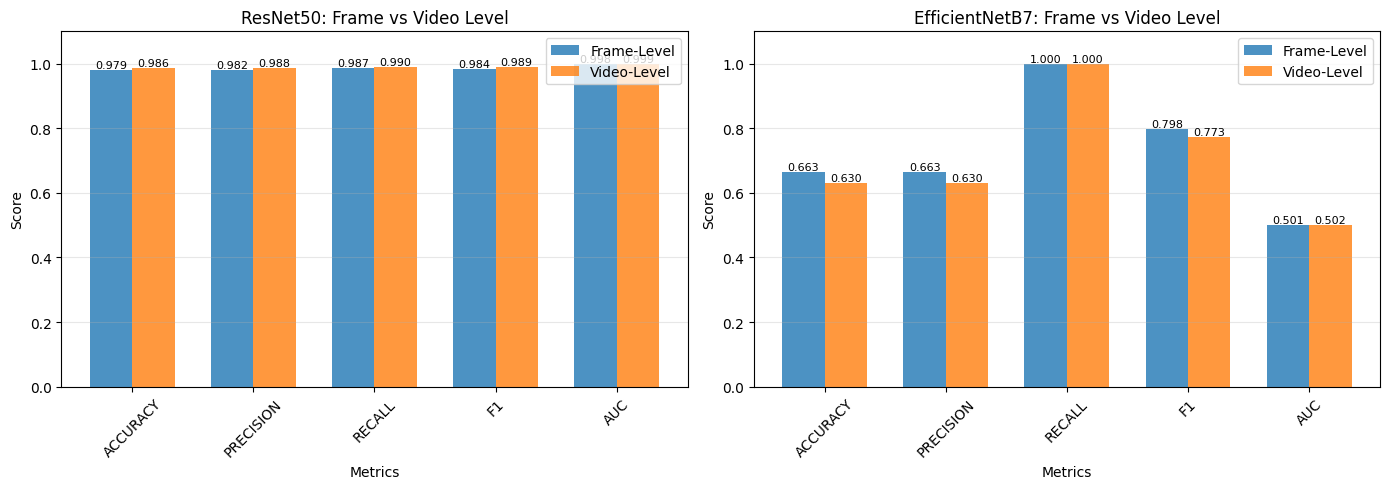

Video-level results saved to: /kaggle/working/plots/video_level_results.csv

VIDEO-LEVEL EVALUATION COMPLETE!

📊 Summary:
   - Total videos evaluated: 1288
   - Frame-level and video-level metrics compared
   - Results saved to: /kaggle/working/plots/video_level_results.csv


In [9]:
print('\n' + '='*80)
print('VIDEO-LEVEL AGGREGATION AND TESTING')
print('='*80)

def extract_video_id_from_filepath(filepath):
    """
    Extract video ID from filepath.
    Expected format: celebdf/real/id0_0000_0001.jpg -> id0_0000
    or celebdf/synthesis/id0_id1_0001.jpg -> id0_id1
    """
    filename = os.path.basename(filepath)
    # Remove frame number (last _XXXX) and extension
    parts = filename.rsplit('_', 1)[0]  # Remove frame index
    return parts


def aggregate_video_predictions(df, predictions, pred_probs):
    """
    Aggregate frame-level predictions to video-level.
    
    Args:
        df: DataFrame with filepaths and labels
        predictions: Frame-level binary predictions
        pred_probs: Frame-level prediction probabilities
    
    Returns:
        DataFrame with video-level aggregated predictions
    """
    # Add predictions to dataframe
    df_pred = df.copy()
    df_pred['pred'] = predictions
    df_pred['pred_prob'] = pred_probs
    
    # Extract video IDs
    df_pred['video_id'] = df_pred['filepath'].apply(extract_video_id_from_filepath)
    
    # Aggregate by video
    video_agg = df_pred.groupby('video_id').agg({
        'label': 'first',  # All frames from same video have same label
        'pred': lambda x: (x.mean() > 0.5).astype(int),  # Majority vote
        'pred_prob': 'mean',  # Average probability
        'filepath': 'count'  # Number of frames per video
    }).rename(columns={'filepath': 'num_frames'})
    
    video_agg['video_pred'] = (video_agg['pred_prob'] > 0.5).astype(int)
    
    return video_agg


def evaluate_video_level(video_agg, model_name):
    """
    Evaluate video-level predictions.
    
    Args:
        video_agg: DataFrame with video-level aggregated predictions
        model_name: Name of the model
    
    Returns:
        Dictionary with video-level metrics
    """
    y_true = video_agg['label'].values
    y_pred = video_agg['video_pred'].values
    y_pred_prob = video_agg['pred_prob'].values
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f'\n=== {model_name} Video-Level Results ===')
    print(f'Total videos: {len(video_agg)}')
    print(f'Real videos: {(y_true == 0).sum()}')
    print(f'Fake videos: {(y_true == 1).sum()}')
    print(f'\nVideo-Level Metrics:')
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'AUC-ROC:   {auc_score:.4f}')
    print(f'\nConfusion Matrix:')
    print(cm)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm,
        'num_videos': len(video_agg)
    }


# ========== RESNET50 VIDEO-LEVEL TESTING ==========
print('\n--- ResNet50 Video-Level Analysis ---')

# Aggregate ResNet50 predictions
video_agg_resnet = aggregate_video_predictions(
    test_df,
    resnet_results['y_pred'],
    resnet_results['y_pred_prob']
)

print(f'\nVideo aggregation summary:')
print(f'Total videos: {len(video_agg_resnet)}')
print(f'Frames per video (mean): {video_agg_resnet["num_frames"].mean():.1f}')
print(f'Frames per video (range): {video_agg_resnet["num_frames"].min()} - {video_agg_resnet["num_frames"].max()}')

video_results_resnet = evaluate_video_level(video_agg_resnet, 'ResNet50')


# ========== EFFICIENTNETB7 VIDEO-LEVEL TESTING ==========
print('\n--- EfficientNetB7 Video-Level Analysis ---')

# Aggregate EfficientNetB7 predictions
video_agg_effnet = aggregate_video_predictions(
    test_df,
    efficientnet_results['y_pred'],
    efficientnet_results['y_pred_prob']
)

video_results_effnet = evaluate_video_level(video_agg_effnet, 'EfficientNetB7')


# ========== COMPARISON: FRAME-LEVEL vs VIDEO-LEVEL ==========
print('\n' + '='*80)
print('FRAME-LEVEL vs VIDEO-LEVEL COMPARISON')
print('='*80)

comparison_data = []

for frame_res, video_res in [(resnet_results, video_results_resnet), 
                              (efficientnet_results, video_results_effnet)]:
    comparison_data.append({
        'Model': frame_res['model_name'],
        'Level': 'Frame',
        'Accuracy': f"{frame_res['accuracy']:.4f}",
        'Precision': f"{frame_res['precision']:.4f}",
        'Recall': f"{frame_res['recall']:.4f}",
        'F1-Score': f"{frame_res['f1']:.4f}",
        'AUC-ROC': f"{frame_res['auc']:.4f}"
    })
    comparison_data.append({
        'Model': video_res['model_name'],
        'Level': 'Video',
        'Accuracy': f"{video_res['accuracy']:.4f}",
        'Precision': f"{video_res['precision']:.4f}",
        'Recall': f"{video_res['recall']:.4f}",
        'F1-Score': f"{video_res['f1']:.4f}",
        'AUC-ROC': f"{video_res['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Visualize frame vs video comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
model_names = ['ResNet50', 'EfficientNetB7']

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    if model_name == 'ResNet50':
        frame_vals = [resnet_results[m] for m in metrics]
        video_vals = [video_results_resnet[m] for m in metrics]
    else:
        frame_vals = [efficientnet_results[m] for m in metrics]
        video_vals = [video_results_effnet[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, frame_vals, width, label='Frame-Level', alpha=0.8)
    bars2 = ax.bar(x + width/2, video_vals, width, label='Video-Level', alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name}: Frame vs Video Level')
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in metrics], rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.1)

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, 'frame_vs_video_comparison.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f'\nFrame vs Video comparison plot saved to: {plot_path}')
plt.show()

# Save video-level results
video_results_path = os.path.join(PLOTS_DIR, 'video_level_results.csv')
video_agg_resnet['model'] = 'ResNet50'
video_agg_effnet['model'] = 'EfficientNetB7'
combined_video_results = pd.concat([video_agg_resnet, video_agg_effnet])
combined_video_results.to_csv(video_results_path, index=True)
print(f'Video-level results saved to: {video_results_path}')


print('\n' + '='*80)
print('VIDEO-LEVEL EVALUATION COMPLETE!')
print('='*80)
print(f'\n📊 Summary:')
print(f'   - Total videos evaluated: {len(video_agg_resnet)}')
print(f'   - Frame-level and video-level metrics compared')
print(f'   - Results saved to: {video_results_path}')
